# Create a Machine Learning Model for Unsupervised Text Topic Classification
Part 1 of 3

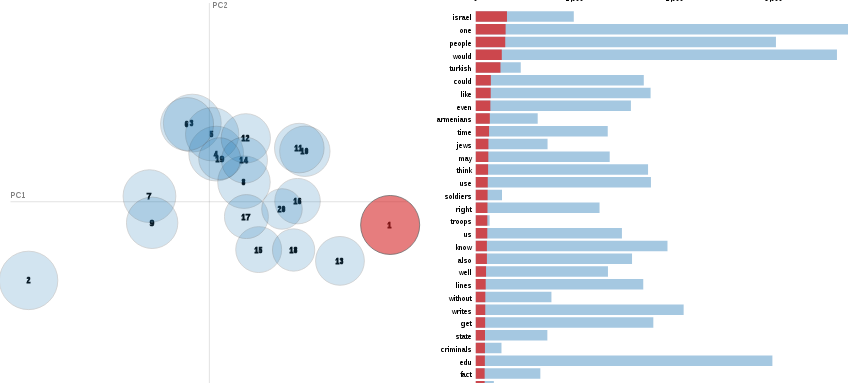
!  [pyLDAvis_2.png](attachment:pyLDAvis_2.png)

## Introduction
In this tutorial notebook we will use the [gensim](https://radimrehurek.com/gensim/about.html) library to create a [Latent Dirichlet allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) machine learning [topic model](https://en.wikipedia.org/wiki/Topic_model). LDA is an _unsupervised_ model, so the topics which are identified during training are assigned a number (for a _label_) and described by a group of terms, where each term is coupled with a weight.

We will use a sample newsgroup dataset [provided by gensim](https://rare-technologies.com/new-api-for-pretrained-nlp-models-and-datasets-in-gensim/) for the purposes of training and scoring.
<a href="url" target="_blank" rel="noopener noreferrer">link text</a>
***
In part 1 of this tutorial notebook series, we will create/train the model, visualize it with [pyLDAvis](http://pyldavis.readthedocs.io/en/latest/) and then save the model on __Bluemix Cloud Object Storage__.

In part 2[LINK], we will create a __Bluemix Streams flow for Streaming Analytics__, which uses the model to perform real-time topic prediction on news items from the dataset. The results will be also be saved to __Bluemix Cloud Object Storage__.

In part 3[LINK], we will visualize the results of the topic predictions.....

Some familiarity with Python is recommended. This notebook has been verified for Python 3.5, Spark 2.1 and gensim 2.2.

## <a id="TOC"></a> Table of contents
1. [Setup](#setup)<br>
    1.1 [Import / Install prerequisite packages](#setup1)<br>
    1.2 [Provide Credentials for Cloud Object Storage (COS)](#setup2)<br>
    1.3 [Provide COS bucket and object names](#setup3)<br>
    1.4 [Download the sample dataset](#setup4)<br>
2. [Define functions](#define)<br>
    2.1 [function: read_dataset](#define1)<br>
    2.2 [function: preprocess_texts](#define2)<br>
    2.3 [function: train_model](#define3)<br>
    2.4 [function: package_mode](#define4)<br>
    2.5 [function: save_to_cos](#define5)<br>
3. [Create the model](#train)<br>
4. [Display a visualization of the topic model](#visualize)<br>
5. [Save the model and topic terms to Cloud Object Storage](#save)<br>
6. [Summary and next steps](#summary)<br>

<a id="setup"></a>
## 1. [Setup](#TOC)

<a id="setup1"></a>
### 1.1 [Import / Install prerequisite packages](#TOC)
Import these packages.
<font color=red>If you get an error</font> on the import statement, remove the <font color=blue>#</font> comment from the pip-install command.  
It is recommended to install gensim version 2.2 as this is the version installed on the _Bluemix Streaming Analytics_ service at the time this notebook was tested.  
If you still get an error on the import, return the comment to the pip-install, restart your kernel and start again (to refresh the sys.path).

In [1]:
#!pip install --user gensim==2.2
from gensim import models, corpora, utils

#!pip install --user pyLDAvis
import pyLDAvis.gensim

Using TensorFlow backend.


<a id="setup2"></a>
### 1.2 [Provide Credentials for Cloud Object Storage (COS)](#TOC)
The COS credentials will be used at the end of this tutorial for storing the created model.

In order to insert your credentials into the notebook, open the `Connections` tab to the right.
* Use the notebook menu bar to open the `Data` panel on the right.
* Select the `Connections` tab.
***
* Click in the empty cell below and select <font color=blue>__insert to code__</font> for your __Cloud Object Storage__ service.
* <font color=red>Change the *name*</font> of the COS credentials variable to __cos_credentials__.
* The dictionary variable should contain the following keys: *iam_url, api_key, resource_instance_id, and url*.
* Add an <font color=red>*additional key*</font> to the variable called __endpoint__.
   * Get the the endpoint value from your Cload Object Storage (COS) service's page.
      * From your Bluemix [Dashboard](https://console.bluemix.net/dashboard/apps), select the COS service.
      * Select `Endpoint` from the menu on the left.
      * Choose the __PUBLIC__ endpoint for your *location* (for example, *us-geo*).
      * Prefix the endpoint value with "https://"

Your variable should look like this...
<div class="alert alert-block alert-success">
```
cos_credentials = {
  'iam_url':'<YOUR-VALUE>',
  'api_key':'<YOUR-VALUE>',
  'resource_instance_id':'<YOUR-VALUE>',
  'url':'<YOUR-VALUE>',

  'endpoint':'https://<YOUR-VALUE>'
}```
</div>

In [2]:
#<INSERT YOUR COS CREDENTIALS, AS EXPLAINED ABOVE>

<a id="setup3"></a>
### 1.3 [Provide COS bucket and object names](#TOC)
Choose a COS bucket name and object names for your packaged model (.gz) and topic-terms (.csv) files. 
<font color=red>Be sure that the bucket already exists!</font>

In [3]:
model_bucket_name = 'pyml'
model_object_name = 'LDA_news.model.pkg.gz'
topic_object_name = 'LDA_news.topic_terms.csv'

In [4]:
# RAANON
cos_credentials_prod_ki = {
  'iam_url':'https://iam.ng.bluemix.net/oidc/token',
  'api_key':'0s-JWmaDBwiSd_yWJqenoKRBfTVU5Rgkz31CDT5WgoWQ',
  'resource_instance_id':'crn:v1:bluemix:public:cloud-object-storage:global:a/db0d062d2b4c0836e18618a5222d8068:22e3b946-6154-4032-8e8f-7cfb0b429602::',
  'url':'https://s3-api.us-geo.objectstorage.service.networklayer.com',
      "endpoint":"https://s3-api.us-geo.objectstorage.softlayer.net",
}
cos_credentials_stage1_wd = {
  'iam_url':'https://iam.stage1.ng.bluemix.net/oidc/token',
  'api_key':'xhjheSC7AhSLtvapSDnbyFn17uWUqW5ccAOuHhQxnnEY',
  'resource_instance_id':'crn:v1:staging:public:cloud-object-storage:global:a/68a66698d275aeb48097f868957ab2ed:bbb5aa36-5525-4000-b129-bcb780195098::',
  'url':'https://s3-api.us-geo.objectstorage.uat.service.networklayer.com',
    'endpoint':'https://s3.us-west.objectstorage.uat.softlayer.net'
}

#cos_credentials = cos_credentials_prod_ki
cos_credentials = cos_credentials_stage1_wd

In [5]:
# Verify credential variables raise Exception('Missing value')
#f = lambda v: [print(v) if len(v) == 0 for v in cos_credentials ]
for k in cos_credentials:
    print('Missing value for', k) if len(cos_credentials.get(k)) == 0 else False

<a id="setup4"></a>
### 1.4 [Download the sample dataset](#TOC)
Version 3.2 of gensim (December 2017) includes a mechanism for [downloading](https://radimrehurek.com/gensim/downloader.html) some sample datasets.
Even if you have a previous version of gensim, you can still download the sample dataset directly from the gensim (RaRe-Technologies) github repository (based on the source code at https://github.com/RaRe-Technologies/gensim/blob/master/gensim/downloader.py).

We will use the __20-newsgroup__ dataset, which is described as: "The notorious collection of approximately 20,000 newsgroup posts, partitioned (nearly) evenly across 20 different newsgroups."

In [6]:
DOWNLOAD_BASE_URL = "https://github.com/RaRe-Technologies/gensim-data/releases/download"
dataset="20-newsgroups"

#!rm -f {dataset}.gz*
![[ ! -f {dataset}.gz ]] && wget '{DOWNLOAD_BASE_URL}/{dataset}/{dataset}.gz'
!pwd && ls -l {dataset}.gz*

/gpfs/fs01/user/sca9-7277eb31bca08b-bc196c953de3/notebook/work
-rw------- 1 sca9-7277eb31bca08b-bc196c953de3 users 14483581 Nov  9 17:44 20-newsgroups.gz


<a id="define"></a>
## 2. [Define functions](#TOC)

<a id="define1"></a>
### 2.1 [function: read_dataset](#TOC)
Load the dataset and create a List of texts. (All stored in memory, so assume a small dataset.) 
The dataset file should be in JSON format and contain a key called 'data'.

Parameters:
* dataset_path: Path and filename of the dataset file.
* max_lines: If greater than 0, abort reading the file after max_lines lines.

Returns:
* data: List of the text documents.

In [7]:
def read_dataset(dataset_path, max_lines=0):
    """
    Read the dataset and return a List of each 'data' entry.
    """
    from smart_open import smart_open
    import json

    print("opening...", dataset_path)
    
    data = []
    with smart_open( dataset_path, 'rb') as infile:
        for i, line in enumerate(infile):
            if max_lines > 0 and i == max_lines:
                break
            jsonData = json.loads(line.decode('utf8'))
            data.append(jsonData['data'])

    print(len(data), "lines read")

    return data

<a id="define2"></a>
### 2.2  [function: preprocess_texts](#TOC)
Steps to pre-process and cleanse texts:
1. Stopword Removal.
2. Collocation detection (bigram).
3. Lemmatization (not stem since stemming can reduce the interpretability).
    
Parameters:
* texts: List of texts.
* stoplist: List of stopword tokens (from nltk.corpus.stopwords.words('english')).
* lemmatizer: [optional] Lemmatizer (from nltk.stem.WordNetLemmatizer()).    

Returns:
* tokens: Pre-processed tokenized texts.
* bigram_phraser: The bigram phraser which was created using all of the training data.

In [8]:
# Adapted from https://github.com/RaRe-Technologies/gensim/blob/master/docs/notebooks/gensim_news_classification.ipynb
def preprocess_texts(texts, stoplist, lemmatizer=None):

    # Convert to lowercase, remove accents, punctuation and digits. Tokenize and remove stop-words.
    tokens = [[word for word in utils.tokenize(text, lowercase=True, deacc=True, errors="ignore")
                     if word not in stoplist]
               for text in texts]

    # bigram collocation detection
    bigram = models.Phrases(tokens)
    bigram_phraser = models.phrases.Phraser(bigram)
    tokens = [bigram_phraser[text] for text in tokens]

    if lemmatizer:
        tokens = [[word for word in lemmatizer.lemmatize(' '.join(text), pos='v').split()] for text in tokens]

    return tokens, bigram_phraser

<a id="define3"></a>
### 2.3 [function: train_model](#TOC)
Steps to create the model
1. Create a Dictionary using the List of cleansed tokenized text.
2. [optional] Filter extremes.
3. Create a corpus from the Bag-of-Words method.  
    The BOW method takes the text tokens (words) and returns a list of tuples containing  
    the word's token-id within the dictionary, and it's frequency within the input text.
4. Create and train an LDA model. Play around with the hyperparameters to affect speed and quality.

Parameters:
* textTokens: List of List of tokens, which are the cleansed text documents.

Results:
* model: The trained LDA model.
* dictionary: The dictionary created from the tokenized text.
* textBOW: The corpus used in creating the model

In [9]:
def train_model( textTokens):

    # Create the dictionary
    dictionary = corpora.Dictionary( documents=textTokens)
    
    # Optional: Filter out tokens which are in less than 10 and more than 75.0% of the documents
    dictionary.filter_extremes(no_below=10, no_above=0.75, keep_n=50000)

    # The training corpus is the result of the Bag-of-Words method.
    textBOW = [dictionary.doc2bow(text) for text in textTokens]

    # Create the gensim LDA model. Choose the best hyper-parameters. For example, try: iterations=100, passes=3
    model = models.ldamodel.LdaModel( corpus=textBOW, id2word=dictionary,
                                      num_topics=20, update_every=0.5,
                                      iterations=10, passes=1) # RECOMMENDED ONLY FOR FASTER TESTING

    return model, dictionary, textBOW

<a id="define4"></a>
### 2.4 [function: package_mode](#TOC)
Package the model, phraser and creation timestamp into a pickled (serialized) and gzip-ed object.

Parameters:
* model: The LDA model
* phraser: The bigram phraser

Results:
* timestamp: The package creation timestamp
* pkg_gz: The compressed package

In [10]:
def package_model( model, phraser):
    import pickle, gzip
    from time import strftime

    timestamp = strftime('%Y-%m-%d_%H.%M.%S')
    pkg = { 'timestamp': timestamp,
            'model': model,
            'phraser': phraser
          }
    pkg_gz = gzip.compress(pickle.dumps(pkg))
    
    return timestamp, pkg_gz

<a id="define5"></a>
### 2.5 [function: save_to_cos](#TOC)
Save an object to Cloud Object Storage (COS) using REST.

Parameters:
* credentials: Dictionary of COS credentials.
* bucket_name: COS bucket_name (must exist!)
* object_name: Name of object to write.
* data: Serialized data to write.

In [11]:
def save_to_cos( credentials, bucket_name, object_name, data):
    import requests

    full_object_path = bucket_name + "/" + object_name
    print("Saving", full_object_path, "(", str(len(data)), "bytes)")

    response = requests.post(
                url = credentials['iam_url'],
                headers = {"Content-Type": "application/x-www-form-urlencoded"},
                params = {"grant_type":"urn:ibm:params:oauth:grant-type:apikey","apikey":credentials['api_key']},
                verify = True)
    if str(response) != "<Response [200]>":
        print( "ERROR: POST Response =", response)
        return
    bearer_token = response.json()["access_token"]
    
    response = requests.put(
                url = credentials['endpoint']+"/"+full_object_path,
                headers = {"Authorization": "bearer " + bearer_token},
                data = data)    
    if str(response) != "<Response [200]>":
        print( "ERROR: PUT Response =", response)

<a id="train"></a>
## 3. [Create the model](#TOC)

* Download the NLTK collection of stop words.
* Download the NLTK lemmatizer used in pre-processing the text.
* Read a subset of the sample dataset to use for training.
* Pre-process and cleanse the text data.
* Train the LDA model.
* Display some of the topic terms identified by the model.

[Optional] Set logging level to display more messages (the gensim library provides many progress messages)

In [12]:
# Optional: Set optional_logging to True to set logging level. Set optional_logging to False to ignore this.
optional_logging = False
if optional_logging:
    import logging
    #Log levels: CRITICAL=50, ERROR=40, WARNING=30, INFO=20, DEBUG=10, NOTSET=0
    logging.basicConfig( level=logging.ERROR, format='%(asctime)s : %(name)s.%(funcName)s : %(levelname)s : %(message)s')
    logger = logging.getLogger()
    logger.setLevel( logging.INFO)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Load the stoplist and lemmatizer from ntlk.download()
import nltk

nltk.download("stopwords")
stoplist = set(nltk.corpus.stopwords.words("english"))

nltk.download("wordnet")
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /gpfs/fs01/user/sca9-7277
[nltk_data]     eb31bca08b-bc196c953de3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /gpfs/fs01/user/sca9-7277eb
[nltk_data]     31bca08b-bc196c953de3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Train the model

In [14]:
# The 20-newsgroups dataset has 18846 entries. Let's take 5000 for training (this is not necessary a recommended ratio).
texts = read_dataset(dataset + ".gz", 5000)

# Pre-process and cleanse the texts
%time textTokens, bigram_phraser = preprocess_texts( texts, stoplist, lemmatizer)

# train the model (save the dictionary and corpus for visualization)
%time model, dictionary, corpus = train_model( textTokens)

# Retrieve the topic terms from the model
topicTerms = model.print_topics(num_topics=-1, num_words=20)

opening... 20-newsgroups.gz
5000 lines read
CPU times: user 32 s, sys: 455 ms, total: 32.5 s
Wall time: 34.4 s
CPU times: user 45.3 s, sys: 1min 22s, total: 2min 7s
Wall time: 1min 8s


In [15]:
# Display a sample (5) of the topic terms
for tt in topicTerms[:5]:
    print("Topic={0}, Terms={1}".format(tt[0],tt[1]), end="\n\n")

Topic=0, Terms=0.008*"public_key" + 0.007*"one" + 0.006*"cryptography" + 0.006*"people" + 0.005*"com" + 0.005*"would" + 0.004*"use" + 0.004*"government" + 0.004*"also" + 0.004*"could" + 0.004*"arabs" + 0.003*"time" + 0.003*"get" + 0.003*"edu" + 0.003*"organization" + 0.003*"like" + 0.003*"know" + 0.003*"writes" + 0.003*"think" + 0.003*"even"

Topic=1, Terms=0.010*"law_enforcement" + 0.007*"would" + 0.007*"use" + 0.007*"one" + 0.005*"people" + 0.004*"turks" + 0.004*"government" + 0.004*"think" + 0.003*"edu" + 0.003*"like" + 0.003*"israel" + 0.003*"get" + 0.003*"turkish" + 0.003*"know" + 0.003*"organization" + 0.003*"lines" + 0.003*"right" + 0.003*"even" + 0.003*"serial_number" + 0.003*"see"

Topic=2, Terms=0.007*"edu" + 0.006*"c" + 0.006*"one" + 0.005*"organization" + 0.005*"writes" + 0.005*"turkish" + 0.005*"would" + 0.005*"like" + 0.004*"get" + 0.004*"armenian" + 0.003*"b" + 0.003*"people" + 0.003*"know" + 0.003*"com" + 0.003*"even" + 0.003*"two" + 0.003*"lines_article" + 0.002*"many"

The result of the above command displays a topic number followed by a group of terms, where each term is coupled with its weight within the topic.

<a id="visualize"></a>
## 4. [Display a visualization of the topic model](#TOC)
We will use the pyLDAvis, which you can read about at http://pyldavis.readthedocs.io/en/latest/ and https://github.com/bmabey/pyLDAvis.  

In [16]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare( model, corpus, dictionary)

pyLDAvis.display(vis)

You can use the interactive visualization to explore the dominant terms of the topics.

<a id="save"></a>
## 5. [Save the model and topic terms to Cloud Object Storage](#TOC)
* Package the model and phraser into a dictionary object, which can be serialized and compressed to a file.
* Save the file to COS.

In [17]:
# Package the model and phraser into a gzip object
ts, pkg_gz = package_model( model, bigram_phraser)
print("Package size: {} bytes; creation timestamp: {}".format(len(pkg_gz), ts))

# Stick the model creation timestamp into the name of the topic-terms file name
topic_object_name_ts = topic_object_name.replace('.csv','') + '.' + ts + '.csv'
print("Modified topic file name: {}".format(topic_object_name_ts))

Package size: 3317186 bytes; creation timestamp: 2018-01-09_09.38.57
Modified topic file name: LDA_news.topic_terms.2018-01-09_09.38.57.csv


In [18]:
# Write both files to COS
save_to_cos( cos_credentials, model_bucket_name, model_object_name, pkg_gz)

save_to_cos( cos_credentials, model_bucket_name, topic_object_name_ts, 
                '\n'.join([str(t[0]) + "," + t[1] for t in topicTerms]))

Saving pyml/LDA_news.model.pkg.gz ( 3317186 bytes)
Saving pyml/LDA_news.topic_terms.2018-01-09_09.38.57.csv ( 6406 bytes)


<a id="summary"></a>
## 6. [Summary and next steps](#TOC)

You have now created an LDA model and saved it to Cloud Object Storage.

Proceed to part 2[LINK], to create a __Bluemix Streams flow for Streaming Analytics__, which uses the model to perform real-time topic prediction on news items from the dataset.

### <a id="authors"></a>Authors
**Raanon Reutlinger** is a developer in the IBM Watson Data Platform team working on the __Streams Designer__ Bluemix (DSX) cloud service. Raanon has over 20 years experience in the IBM Software Group, working in Data Management, Big Data and Watson teams.
<hr>
Copyright &copy; IBM Corp. 2017,2018. This notebook and its source code are released under the terms of the MIT License.